Quantile regression was fitted on the initial 50% of the data - as a training set.
Then the dependent variable was forecasted and traded using a strategy.
STRATEGY OUTLINE: If (forecast.next_n_period - current_price > X points, then buy asset,
forecast.next_n_period - current_price < X points, then sell asset).
n,X were cherry picked and basic strategy parameters were reported

## Importing libraries and cleaning the data

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import seaborn as sns
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
sns.set(rc={'figure.figsize':(16,12),"figure.dpi":400, 'savefig.dpi':400})

import warnings
warnings.filterwarnings("ignore")

In [2]:
main_df = pd.read_csv('./quantile_raw.csv')
df = main_df

In [235]:
df.head(5)

,t,k200,k200volume,k200_wn,fprc,fvolume,f_wn,vkospi,iv1,iv2,...,iv2_atm,iv2_otm,iv3,iv3_Call,iv3_put,iv3_itm,iv3_atm,iv3_otm,dop,dcl
0,2005-01-03 10:01,115.65,6971224.0,8.813920e+10,116.00,2658.0,1.540000e+11,NaN,20.879310,28.419010,...,19.726609,29.636174,24.784842,19.833360,28.415928,21.272830,20.700473,26.536521,0,0
1,2005-01-03 10:02,115.54,915131.0,9.772912e+09,116.00,1486.0,8.618300e+10,NaN,21.112680,23.072276,...,20.301699,23.799501,24.683726,20.555183,27.986560,21.365015,20.928948,26.464211,0,0
2,2005-01-03 10:03,115.42,771750.0,9.474952e+09,116.00,1214.0,7.039850e+10,NaN,21.336045,22.517448,...,21.043458,22.964765,23.515884,21.098337,26.537817,21.543264,21.079843,25.045842,0,0
3,2005-01-03 10:04,115.55,991206.0,9.716512e+09,116.05,1876.0,1.090000e+11,NaN,20.977045,21.688313,...,20.463135,22.800739,24.261755,20.575309,27.640997,21.749790,20.930062,25.341208,0,0
4,2005-01-03 10:05,115.60,1053666.0,1.272223e+10,115.80,2064.0,1.200000e+11,NaN,20.863665,22.366039,...,19.634384,23.386053,24.308382,19.610685,27.538049,21.211115,21.128049,25.889319,0,0


In [12]:
df['dop'] = 0
df['dcl'] = 0
dfx = df.set_index('t')

dfx['hourmin'] = dfx.index
dfx['hourmin'] = dfx['hourmin'].apply(lambda x: int(x[-5:-3])*60 + int(x[-2:]))
dop = (dfx['hourmin'] <= 599)
dfx.loc[(dop,"dop")] = 1
dcl = (dfx['hourmin']>=830)
dfx.loc[(dcl,"dcl")] = 1

dfx.reset_index(inplace = True)

In [236]:
dfx.fillna(method='ffill', inplace=True)
print(dfx.isna().sum())

## Setting up the dataframe for regression

In [14]:
dfx['lsv']=np.log(dfx['k200_wn']+1e-12)  #1e-12 added for 0 values in k200_wn 
dfx['lfv']=np.log(dfx['f_wn'])
dfx['r']= 100*dfx['k200'].pct_change()
dfx['div']=dfx['iv2'].diff()

In [15]:
df2 = dfx[['r','lsv','lfv','div']]
df2.dropna(inplace = True)

In [17]:
df2_reg1 = dfx[['t','hourmin','div','r','lsv','lfv','dop','dcl']]

In [19]:
df2_reg1.dropna(inplace = True)

In [23]:
N = len(df2_reg1.index)
df2_reg1_train = df2_reg1[0:int(N/2)]     #TRAINING DATA

In [40]:
df2_reg1 = dfx[['t','hourmin','k200','r','lsv','lfv','dop','dcl']]
df2_reg1_pred = df2_reg1[int(N/2):]      

In [42]:
#Calculation of time trend terms
df2_reg1_train.rename(columns = {'t': 'time'},inplace = True)
df2_reg1_train['tbyT'] = df2_reg1_train.index/len(df2_reg1_train.index)
df2_reg1_train['t2byT2'] = df2_reg1_train['tbyT']**2

df2_reg1_pred.rename(columns = {'t': 'time'},inplace = True)
df2_reg1_pred['tbyT'] = (df2_reg1_pred.index - 410892)/len(df2_reg1_pred.index)
df2_reg1_pred['t2byT2'] = df2_reg1_pred['tbyT']**2


In [28]:
#Calculation of lagged values of r, lsv, lfv and fs (with outliers)
df2_reg1_train["r1"] = df2_reg1_train["r"].shift(1)
df2_reg1_train["r2"] = df2_reg1_train["r"].shift(2)
df2_reg1_train["r3"] = df2_reg1_train["r"].shift(3)

df2_reg1_train["r1sq"] = df2_reg1_train["r1"]**2
df2_reg1_train["r2sq"] = df2_reg1_train["r2"]**2
df2_reg1_train["r3sq"] = df2_reg1_train["r3"]**2

df2_reg1_train["lsv1"] = df2_reg1_train["lsv"].shift(1)
df2_reg1_train["lsv2"] = df2_reg1_train["lsv"].shift(2)
df2_reg1_train["lsv3"] = df2_reg1_train["lsv"].shift(3)

df2_reg1_train["lfv1"] = df2_reg1_train["lfv"].shift(1)
df2_reg1_train["lfv2"] = df2_reg1_train["lfv"].shift(2)
df2_reg1_train["lfv3"] = df2_reg1_train["lfv"].shift(3)

df2_reg1_train["fs1"] = df2_reg1_train["lfv1"] - df2_reg1_train["lsv1"]
df2_reg1_train["fs2"] = df2_reg1_train["lfv2"] - df2_reg1_train["lsv2"]
df2_reg1_train["fs3"] = df2_reg1_train["lfv3"] - df2_reg1_train["lsv3"]

df2_reg1_train.dropna(inplace = True)

In [43]:
#Calculation of lagged values of r, lsv, lfv and fs (with outliers)
df2_reg1_pred["r1"] = df2_reg1_pred["r"].shift(1)
df2_reg1_pred["r2"] = df2_reg1_pred["r"].shift(2)
df2_reg1_pred["r3"] = df2_reg1_pred["r"].shift(3)

df2_reg1_pred["r1sq"] = df2_reg1_pred["r1"]**2
df2_reg1_pred["r2sq"] = df2_reg1_pred["r2"]**2
df2_reg1_pred["r3sq"] = df2_reg1_pred["r3"]**2

df2_reg1_pred["lsv1"] = df2_reg1_pred["lsv"].shift(1)
df2_reg1_pred["lsv2"] = df2_reg1_pred["lsv"].shift(2)
df2_reg1_pred["lsv3"] = df2_reg1_pred["lsv"].shift(3)

df2_reg1_pred["lfv1"] = df2_reg1_pred["lfv"].shift(1)
df2_reg1_pred["lfv2"] = df2_reg1_pred["lfv"].shift(2)
df2_reg1_pred["lfv3"] = df2_reg1_pred["lfv"].shift(3)

df2_reg1_pred["fs1"] = df2_reg1_pred["lfv1"] - df2_reg1_pred["lsv1"]
df2_reg1_pred["fs2"] = df2_reg1_pred["lfv2"] - df2_reg1_pred["lsv2"]
df2_reg1_pred["fs3"] = df2_reg1_pred["lfv3"] - df2_reg1_pred["lsv3"]

df2_reg1_pred.dropna(inplace = True)

In [30]:
from statsmodels.tsa.ar_model import AutoReg

In [31]:
# Autoregressions to get the trading volume shocks
mod = AutoReg(df2_reg1_train['lsv'], 3, old_names=False)
res = mod.fit()
df2_reg1_train['lsv_hat'] = res.params[0] + res.params[1]*df2_reg1_train['lsv1'] + res.params[2]*df2_reg1_train['lsv2'] + res.params[3]*df2_reg1_train['lsv3']
df2_reg1_train['lsvs'] = df2_reg1_train['lsv'] - df2_reg1_train['lsv_hat']

mod = AutoReg(df2_reg1_train['lfv'], 3, old_names=False)
res = mod.fit()
df2_reg1_train['lfv_hat'] = res.params[0] + res.params[1]*df2_reg1_train['lfv1'] + res.params[2]*df2_reg1_train['lfv2'] + res.params[3]*df2_reg1_train['lfv3']
df2_reg1_train['lfvs'] = df2_reg1_train['lfv'] - df2_reg1_train['lfv_hat']

df2_reg1_train['fss'] = df2_reg1_train['lfvs'] - df2_reg1_train['lsvs']

In [45]:
# Autoregressions to get the trading volume shocks
mod = AutoReg(df2_reg1_pred['lsv'], 3, old_names=False)
res = mod.fit()
df2_reg1_pred['lsv_hat'] = res.params[0] + res.params[1]*df2_reg1_pred['lsv1'] + res.params[2]*df2_reg1_pred['lsv2'] + res.params[3]*df2_reg1_pred['lsv3']
df2_reg1_pred['lsvs'] = df2_reg1_pred['lsv'] - df2_reg1_pred['lsv_hat']

mod = AutoReg(df2_reg1_pred['lfv'], 3, old_names=False)
res = mod.fit()
df2_reg1_pred['lfv_hat'] = res.params[0] + res.params[1]*df2_reg1_pred['lfv1'] + res.params[2]*df2_reg1_pred['lfv2'] + res.params[3]*df2_reg1_pred['lfv3']
df2_reg1_pred['lfvs'] = df2_reg1_pred['lfv'] - df2_reg1_pred['lfv_hat']

df2_reg1_pred['fss'] = df2_reg1_pred['lfvs'] - df2_reg1_pred['lsvs']

In [32]:
#Calculation of lagged values of lsvs, lfvs and fss (with outliers)
df2_reg1_train["lsvs1"] = df2_reg1_train["lsvs"].shift(1)
df2_reg1_train["lsvs2"] = df2_reg1_train["lsvs"].shift(2)
df2_reg1_train["lsvs3"] = df2_reg1_train["lsvs"].shift(3)

df2_reg1_train["lfvs1"] = df2_reg1_train["lfvs"].shift(1)
df2_reg1_train["lfvs2"] = df2_reg1_train["lfvs"].shift(2)
df2_reg1_train["lfvs3"] = df2_reg1_train["lfvs"].shift(3)

df2_reg1_train["fss1"] = df2_reg1_train['fss'].shift(1)
df2_reg1_train["fss2"] = df2_reg1_train['fss'].shift(2)
df2_reg1_train["fss3"] = df2_reg1_train['fss'].shift(3)

df2_reg1_train.dropna(inplace = True)

In [46]:
#Calculation of lagged values of lsvs, lfvs and fss (with outliers)
df2_reg1_pred["lsvs1"] = df2_reg1_pred["lsvs"].shift(1)
df2_reg1_pred["lsvs2"] = df2_reg1_pred["lsvs"].shift(2)
df2_reg1_pred["lsvs3"] = df2_reg1_pred["lsvs"].shift(3)

df2_reg1_pred["lfvs1"] = df2_reg1_pred["lfvs"].shift(1)
df2_reg1_pred["lfvs2"] = df2_reg1_pred["lfvs"].shift(2)
df2_reg1_pred["lfvs3"] = df2_reg1_pred["lfvs"].shift(3)

df2_reg1_pred["fss1"] = df2_reg1_pred['fss'].shift(1)
df2_reg1_pred["fss2"] = df2_reg1_pred['fss'].shift(2)
df2_reg1_pred["fss3"] = df2_reg1_pred['fss'].shift(3)

df2_reg1_pred.dropna(inplace = True)

In [240]:
df2_reg1_train.head()

,time,hourmin,div,r,lsv,lfv,dop,dcl,tbyT,t2byT2,...,fss,lsvs1,lsvs2,lsvs3,lfvs1,lfvs2,lfvs3,fss1,fss2,fss3
7,2005-01-03 10:08,608,-0.054032,0.129859,23.027346,24.771089,0,0,0.000017,2.902275e-10,...,-0.388270,-0.184201,0.062154,0.295375,0.381223,0.252750,0.502838,0.565423,0.190596,0.207464
8,2005-01-03 10:09,609,-1.197316,0.069168,22.839656,23.765562,0,0,0.000019,3.790727e-10,...,-0.908698,0.006647,-0.184201,0.062154,-0.381623,0.381223,0.252750,-0.388270,0.565423,0.190596
9,2005-01-03 10:10,610,0.299510,-0.095041,22.924941,24.326326,0,0,0.000022,4.797639e-10,...,-0.065304,-0.178658,0.006647,-0.184201,-1.087356,-0.381623,0.381223,-0.908698,-0.388270,0.565423
10,2005-01-03 10:11,611,1.456779,-0.242152,22.955738,25.131353,0,0,0.000024,5.923011e-10,...,0.803700,0.047027,-0.178658,0.006647,-0.018277,-1.087356,-0.381623,-0.065304,-0.908698,-0.388270
11,2005-01-03 10:12,612,-0.264052,0.034677,22.925101,24.647907,0,0,0.000027,7.166843e-10,...,0.085166,0.038294,0.047027,-0.178658,0.841994,-0.018277,-1.087356,0.803700,-0.065304,-0.908698


## Training the data

In [127]:
# Quantile regression using lfv
results = []
q_val = [0.05, 0.1, 0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.67, 0.75, 0.8, 0.9,0.95]

for q in q_val:
    mod = smf.quantreg("r ~ tbyT + t2byT2 + dop + dcl + r1 + r2 + r3 + r1sq + r2sq + r3sq + lfv1 + lfv2 + lfv3", df2_reg1_train)
    res = mod.fit(q = q)
    print("q Value =", q)
    results.append(res.params)

q Value = 0.05
q Value = 0.1
q Value = 0.2
q Value = 0.25
q Value = 0.33
q Value = 0.4
q Value = 0.5
q Value = 0.6
q Value = 0.67
q Value = 0.75
q Value = 0.8
q Value = 0.9
q Value = 0.95


In [131]:
for i in range(len(q_val)):
    c = results[i]
    df2_reg1_pred['r_hat_' + str(q_val[i])] = c[0] + c[1]*df2_reg1_pred["tbyT"] + c[2]*df2_reg1_pred["t2byT2"] + c[3]*df2_reg1_pred["dop"] + c[4]*df2_reg1_pred["dcl"] + c[5]*df2_reg1_pred["r1"] + c[6]*df2_reg1_pred["r2"] + c[7]*df2_reg1_pred["r3"] + c[8]*df2_reg1_pred["r1sq"] + c[9]*df2_reg1_pred["r2sq"] + c[10]*df2_reg1_pred["r3sq"] + c[11]*df2_reg1_pred["lfv1"] + c[12]*df2_reg1_pred["lfv2"] + c[13]*df2_reg1_pred["lfv3"]

In [241]:
df2_reg1_pred.head()       #DATAFRAME USED FOR IMPLEMENTING THE STRATEGY

,time,hourmin,k200,r,lsv,lfv,dop,dcl,tbyT,t2byT2,...,r_hat_0.25,r_hat_0.5,r_hat_0.75,r_hat_0.8,r_hat_0.9,r_hat_0.95,r_hat_0.33,r_hat_0.4,r_hat_0.6,r_hat_0.67
410899,2009-09-29 14:32,872,221.56,0.094872,23.453757,22.331323,0,1,0.000017,2.902247e-10,...,-0.032296,0.001784,0.036959,0.046600,0.075210,0.101836,-0.020433,-0.010955,0.014705,0.024406
410900,2009-09-29 14:33,873,221.54,-0.009027,23.353401,24.574545,0,1,0.000019,3.790690e-10,...,-0.013679,0.009136,0.036188,0.044350,0.067732,0.089354,-0.005984,0.000678,0.019020,0.026499
410901,2009-09-29 14:34,874,221.50,-0.018055,23.484392,24.475459,0,1,0.000022,4.797592e-10,...,-0.026250,0.003710,0.033839,0.041549,0.063475,0.083123,-0.015293,-0.007134,0.015229,0.023148
410902,2009-09-29 14:35,875,221.57,0.031603,23.556421,21.415125,0,1,0.000024,5.922953e-10,...,-0.030352,-0.001108,0.026440,0.033929,0.054159,0.072139,-0.019759,-0.011785,0.009161,0.017038
410903,2009-09-29 14:36,876,221.49,-0.036106,23.593006,23.852686,0,1,0.000027,7.166773e-10,...,-0.018071,0.002928,0.026144,0.033156,0.053055,0.071059,-0.010715,-0.004591,0.011422,0.017819


## Trading Strategy
THOUGHT PROCESS

1) Using equation[6] of the paper, we can predict r(t) for any quantile with the data available till t-1.

2) r(T)(Q) = predicted return at time T for quantile Q.

3) At t-1, we can predict r(t)(0.25), r(t)(0.5) and r(t)(0.75)

4) If r(t)(0.25) > 0, then there is roughly a 75% chance that Kospi200(t) > Kospi200(t-1). Similary, for r(t)(0.75) < 0, there is roughly a 75% chance that the return will be negative.

5) Initially, I went long when r(t)(0.25) > 0 and short when r(t)(0.75) < 0. The drawback of this strategy was that number of trading signals generated were less.

6) I then tried a similar approach for r(t)(0.5) > 0 and r(t)(0.5) < 0. However, in this too many trading signals were generated  and profits went down.

7) Thus, I opted for a weighted mean of the signals given in 5) and 6) to arrive at the final strategy (weights were obtained through brute force).

FINAL STRATEGY

Long signal: 0.28 * r(t)(0.25) + 0.72 * r(t)(0.5) > 0   (Sell in the next timestep (minute)).

Short signal: 0.28 * r(t)(0.75) + 0.72 * r(t)(0.5) < 0  (Cover in the next timestep (minute)).

In [223]:
# INITIALIZING VARIABLES

is_long = False
is_short = False
capital = pd.Series(1_000_000, index = df2_reg1_pred.index)
num_short_trades = 0
num_long_trades = 0

for i in tqdm(range(df2_reg1_pred.index[0], df2_reg1_pred.index[-1])):
     
    if(i >= df2_reg1_pred.index[1]):
        capital[i] = capital[i-1]
    
    #LONG EXIT
    if is_long:
        is_long = False
        sellprice = df2_reg1_pred['k200'][i]
        capital[i] = capital[i] + num_shares*(sellprice - buyprice)
        num_long_trades = num_long_trades + 1
        #continue
    
    #SHORT EXIT    
    if is_short:
        is_short = False
        coverprice = df2_reg1_pred['k200'][i]
        capital[i] = capital[i] + num_shares*(shortprice - coverprice)
        num_short_trades = num_short_trades + 1
        #continue
    
    #LONG ENTRY    
    if is_long == False and is_short == False and (0.28*df2_reg1_pred['r_hat_0.25'][i+1] + 0.72*df2_reg1_pred['r_hat_0.5'][i+1]) > 0:
        is_long = True
        buyprice = df2_reg1_pred['k200'][i]
        num_shares = int(capital[i]/ buyprice)
    
    #SHORT ENTRY
    if is_long == False and is_short == False and (0.28*df2_reg1_pred['r_hat_0.75'][i+1] + 0.72*df2_reg1_pred['r_hat_0.5'][i+1]) < 0:
        is_short = True
        shortprice = df2_reg1_pred['k200'][i]
        num_shares = int(capital[i]/ shortprice)
        
capital[df2_reg1_pred.index[-1]] =   capital[df2_reg1_pred.index[-1] - 1]     

100%|███████████████████████████████████████████████████████████████████████| 410888/410888 [00:17<00:00, 23195.65it/s]


In [242]:
print('Initial capital: 1000000' )
print('Number of short trades:', num_short_trades)
print('Number of long trades:', num_long_trades)
print('Final capital:', capital[df2_reg1_pred.index[-1]])
cagr = (4.035**(1/4.75) - 1)*100
print('CAGR(%):',cagr )
print("In this strategy, trading costs were assumed to be 0. After taking trading costs into consideration, the CAGR could come down significantly.")

Initial capital: 1000000
Number of short trades: 7944
Number of long trades: 5750
Final capital: 4034923
CAGR(%): 34.13620288852572
In this strategy, trading costs were assumed to be 0. After taking trading costs into consideration, the CAGR could come down significantly.


Text(0, 0.5, 'Capital')

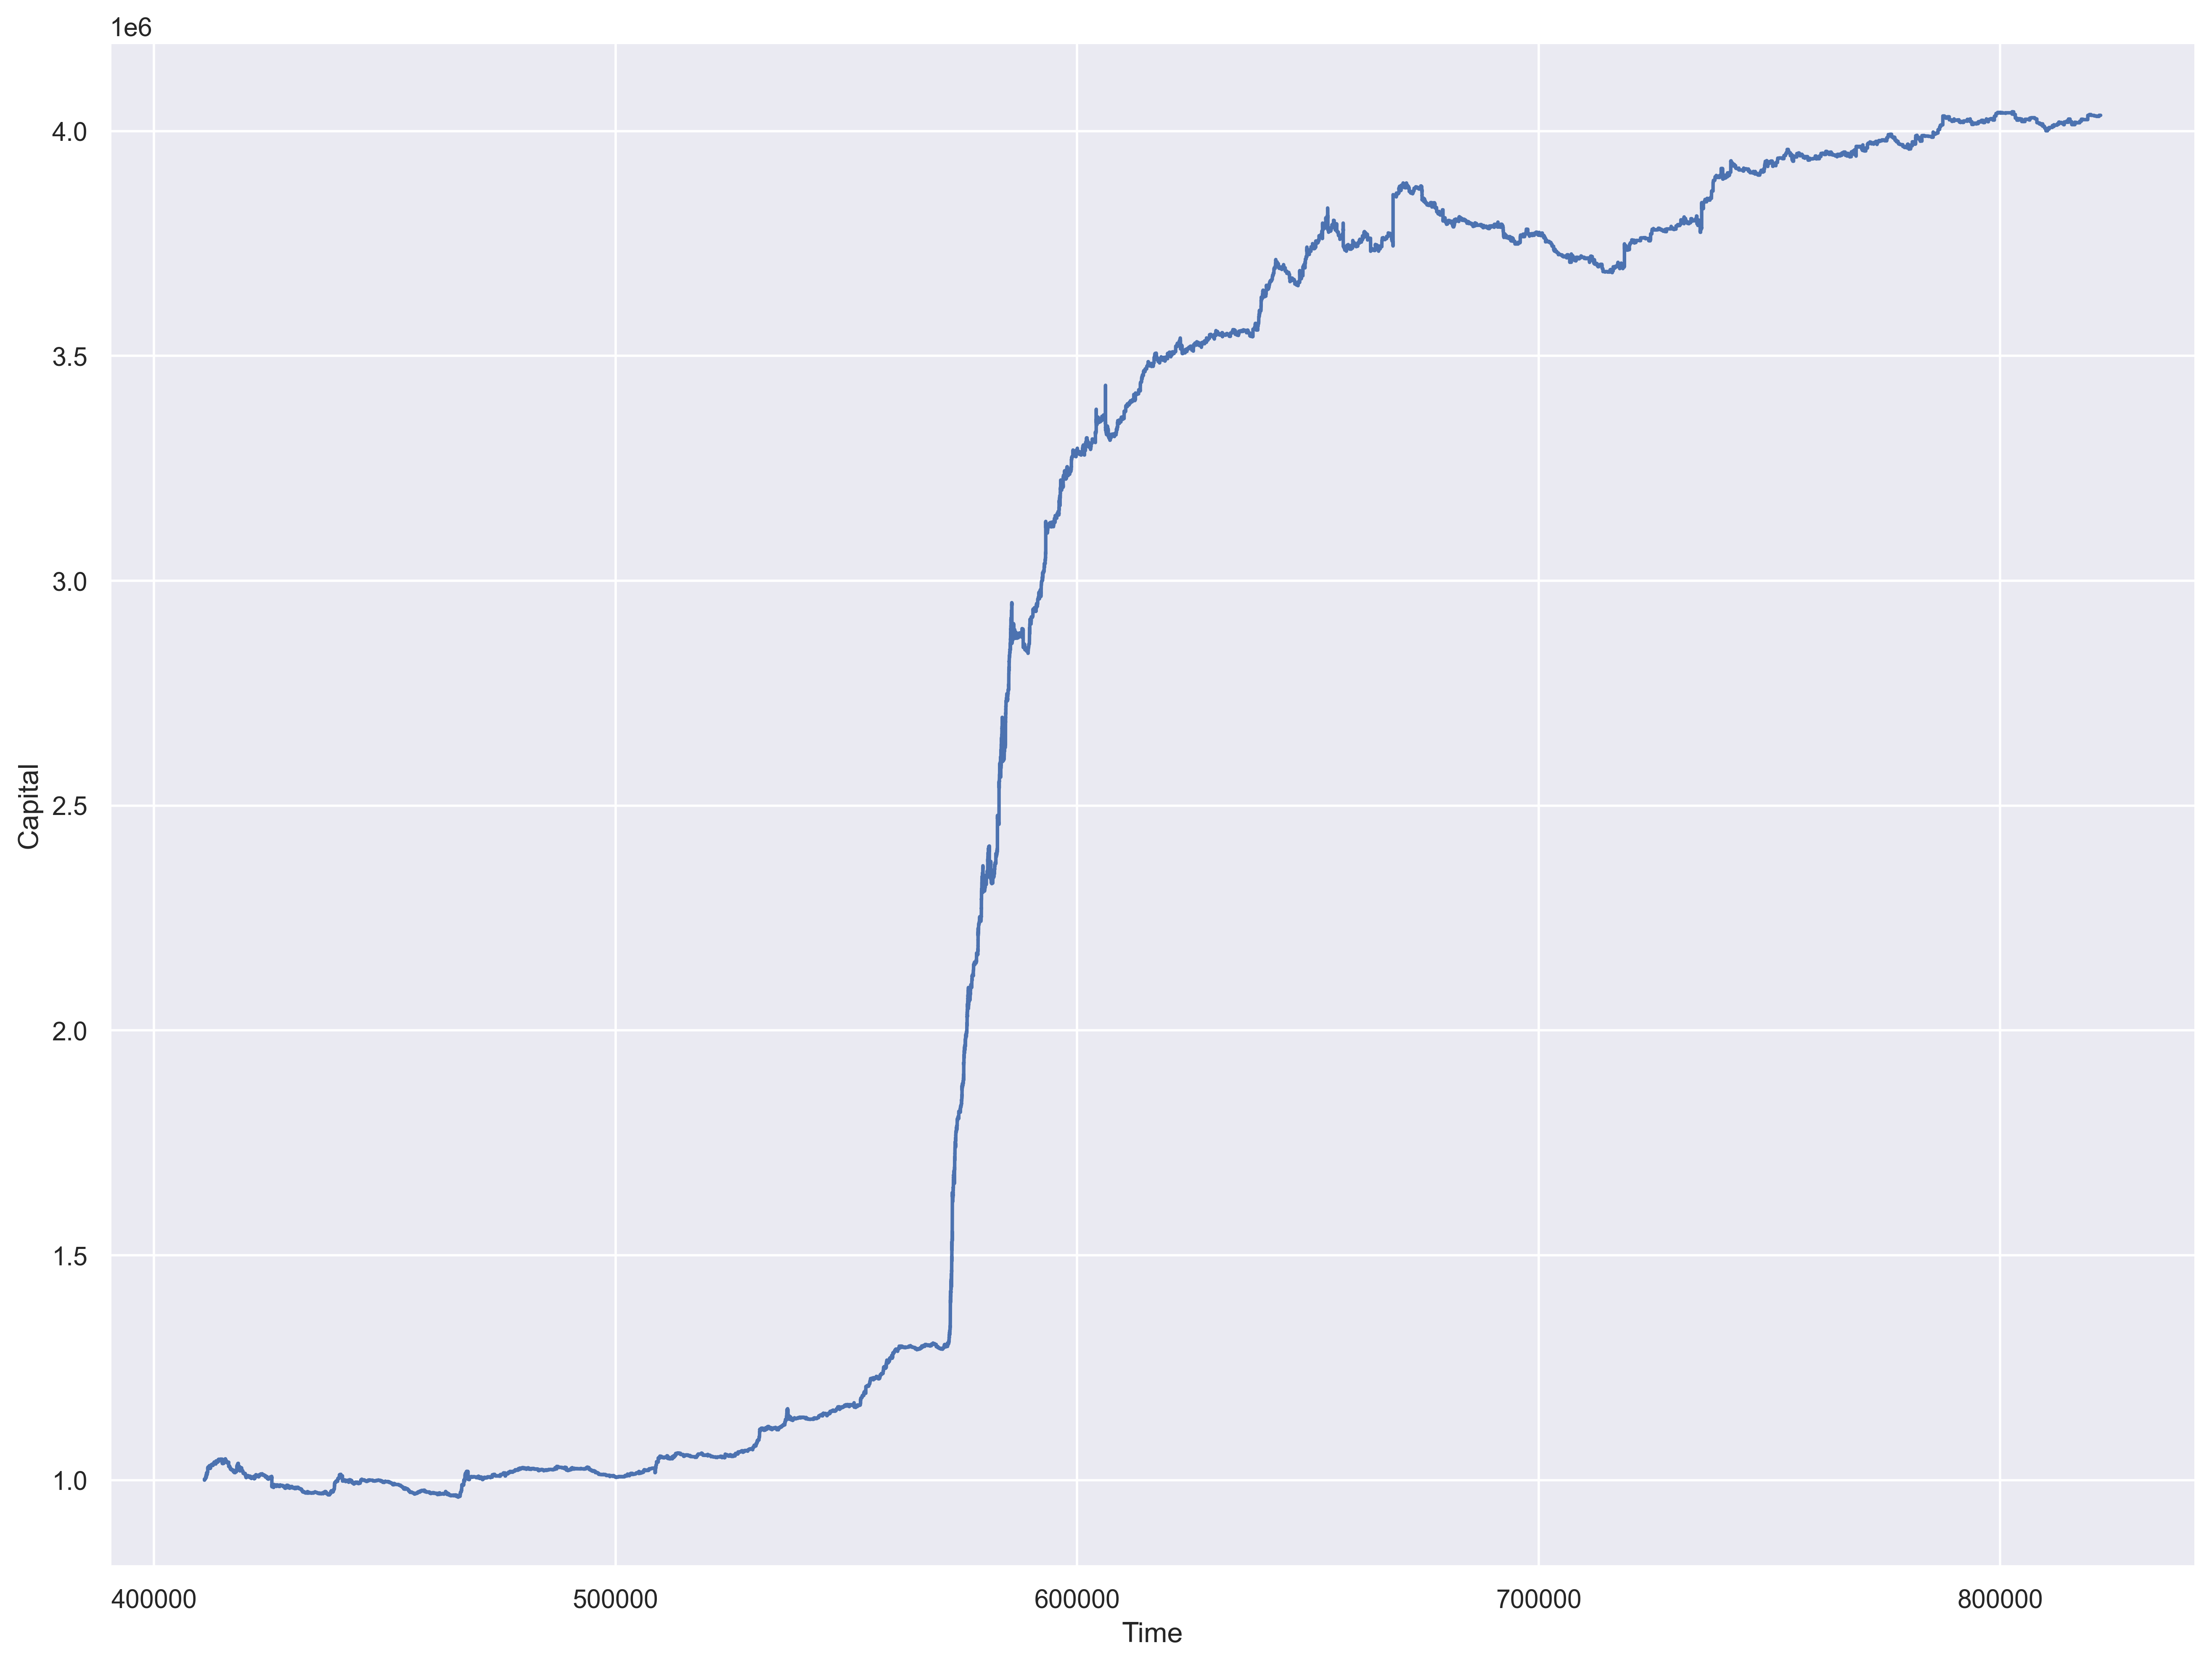

In [244]:
capital.plot()
plt.xlabel('Time')
plt.ylabel('Capital')